## An example second order ODE

I will discuss how we go about solving a second order ordinary differential equation (ODE), motivating the use of first order ODE solvers as we go.

We will consider the charge in a circuit with an inductor, a resistor and a capacitor (LRC), which obeys the equation:
$$L\frac{d^2q}{dt^2} + R\frac{dq}{dt} + \frac{1}{C}q = 0$$

We could solve this using a centred finite difference formulae for both first and second order differentials, though this would only give us a solution that was second order in the timestep.  By reformulating it as coupled first order ODEs we can use very accurate methods such as RK4.

To help understand this reformulation, let's consider a *vector* first order ODE for position $\mathbf{r} = (x,y)$:
$$\frac{d\mathbf{r}}{dt} = \mathbf{g}(\mathbf{r},t)$$
We'll assume that $\mathbf{g} = (-Ay,Bx)$ and we then write out the components of the vectors:
$$\frac{dx}{dt} = -Ay$$
$$\frac{dy}{dt} = Bx$$
It should be clear that this is the same as the vector equation.  When we perform a numerical integration to solve this equation on the computer, we have to solve the two equations simultaneously.  We would do this by writing a function for the right hand side of the equation that returned an array `rhs = [-Ay, Bx]`, and we could then solve for the behaviour of the system by incrementing, using something like: `r[i+1] = r[i] + dt*rhs(r[i],t)`.

The key point to understand is that we can write the second order ODE for the charge (above) as coupled first order ODEs in exactly the same way:
$$\frac{dq}{dt} = I$$
$$\frac{dI}{dt} = -\frac{R}{L}I - \frac{1}{LC}q$$
If we use the simple Euler method here, then we can define $\Delta q = I\Delta t$ and $\Delta I = (-RI/L - q/LC)\Delta t$.  To implement this computationally, we define an array `y = [q, I]` and an update function that returns `dy = [I, -RI/L - q/LC]`, and we can solve this second order equation in the same way as the vector first order equation.  There are two ideas to grasp here: 

* The rewriting of the second order ODE as coupled first order ODEs; this is purely maths, not computational physics
* The computational trick of treating the two parts of the second order ODE as if they were components of a vector, so that we can use first order ODE solvers

We'll now do this in code; we'll first use Euler's method as it is so simple.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

We have to define a function for the right-hand side of the equation.  Note that this function is *continuous* in $y$ and $t$: we need it to return the right-hand side for arbitrary values of $t$ and $y$.  This contrasts strongly to the calculation we do with the Euler method, or the RK4 method, where we are using an array for $y$ and only finding values at specific steps.  In this case, we also pass three extra parameters (the inductance, resistance and capacitance of the circuit).

In [2]:
def fun_rhs(t, y, L, R, C):
    """Calculates the right hand side of coupled first order ODEs

    Inputs:
    t time
    y array of two variables
    L Inductance
    R Resistance
    C Capacitance
    
    Output:
    Array of differentials
    """
    # Unpack q and I from y
    q, I = y
    dq = I
    dI = -I*R/L - q/(L*C)
    # Return array of differentials
    return np.array([dq, dI])
    

### Euler solver

We will now solve for the charge as a function of time.  First we set up the calculation.

In [3]:
# Constants
L = 0.15 # Henry
R = 12.0  # Ohm
C = 100e-6 # Farad

# The natural frequency is ~41 Hz, and we want about 4 periods, or ~0.1s
N = 1000
dt = 0.1/N # s

# Initial state: empty capacitor (zero charge)
y0 = [0,5.1]

# Storage for results
y = np.zeros((N+1,2))

And now we use a simple loop to implement Euler's method

In [4]:
y[0] = y0
t = 0.0
for i in range(N):
    y[i+1] = y[i] + dt*fun_rhs(t,y[i],L,R,C)
    t += dt

And we can plot the resulting charge and current

Text(0, 0.5, 'Current/A')

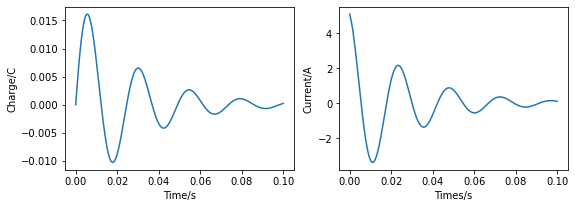

In [5]:
t = np.linspace(0,dt*N,N+1)
fig1, ax1 = plt.subplots(1,2,figsize=(9,3))
ax1[0].plot(t,y[:,0])
ax1[0].set_xlabel("Time/s")
ax1[0].set_ylabel("Charge/C")
ax1[1].plot(t,y[:,1])
ax1[1].set_xlabel("Times/s")
ax1[1].set_ylabel("Current/A")

### Using SciPy solver

We'll now use the `integrate.solve_ivp` solver to illustrate how this works.  Note that you must have a SciPy version of 1.4 or above for this to work.  We won't specify the times where we want the solution, so the solver will determine these itself. (If you want, you could try adding the argument `t_eval=t` to the call to evaluate the solution at the points defined in the array `t` above.)  Note that this illustrates how we pass extra parameters to the function via the SciPy call.

In [6]:
from scipy import integrate

# Time period
t_span = (0,0.1)
# Notice how we pass the arguments L, R and C to our fun_rhs
result = integrate.solve_ivp(fun_rhs,t_span,y0,args=(L,R,C))

Text(0, 0.5, 'Current/A')

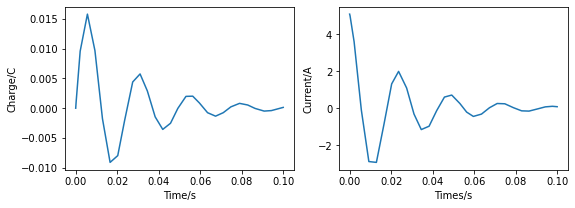

In [7]:
fig2, ax2 = plt.subplots(1,2,figsize=(9,3))
ax2[0].plot(result.t,result.y[0])
ax2[0].set_xlabel("Time/s")
ax2[0].set_ylabel("Charge/C")
ax2[1].plot(result.t,result.y[1])
ax2[1].set_xlabel("Times/s")
ax2[1].set_ylabel("Current/A")

These show that our simple Euler solution was relatively accurate for this simulation (we chose a small enough time step)